## Predictive Modeling (Combining Clay and Hard Court into a Single Model)
* This was done strictly as a control analysis for the reporting stage
* To be clear, most features usedin this modeling variant were still generated (see notebook 2) on a surface-specific basis. Though any that have the nss suffix were generated on a non-surface specific basis.
* Given the above, what makes this analysis variant distinct is that both hard court and clay court matches are included in the actual modeling stage here. 
    * This analysis was run separately for unequal sample sizes between clay and hard courts, as well as for equal sample size for both. Furthermore, both of these subvariants were run using only 2015-2019 for the modeling stage (recall that the "best" clay court model actually uses 2012-2019 at the modeling stage). 

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
#from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.dummy import DummyRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
#from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load and Filter Data

Filtering parameters identical to in dummy/simple modeling stage. 

In [737]:
# This is the file and analysis data range used for variable time range analyses for either surface
df = pd.read_csv('../data/df_for_modeling.csv')
df.head()

,p_tot_pts_won%,t_ident,t_surf,t_ind,t_alt,t_draw_sz,t_lvl,m_bestof,m_num,m_date,...,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff
0,54.19,91,2,1,0,8,3,3,28534,2019-11-17,...,-0.02,-0.01,-0.01,-0.01,-0.02,-0.01,-0.02,0.00,-0.02,0.00
1,45.81,91,2,1,0,8,3,3,28534,2019-11-17,...,0.02,0.01,0.01,0.01,0.02,0.01,0.02,0.00,0.02,0.00
2,53.15,91,2,1,0,8,3,3,28533,2019-11-16,...,-0.01,0.01,0.00,0.01,-0.01,0.01,0.00,0.01,-0.01,0.00
3,46.85,91,2,1,0,8,3,3,28533,2019-11-16,...,0.01,-0.01,0.00,-0.01,0.01,-0.01,0.00,-0.01,0.01,0.00
4,54.74,91,2,1,0,8,3,3,28532,2019-11-16,...,-0.03,-0.02,-0.05,-0.03,-0.03,-0.02,-0.05,-0.03,-0.04,-0.03


In [655]:
# This cell for use in combined model (hard and clay in same model) with NON-equal samples per surface only

# Getting full sample of clay court matches (applying other standard filters)
# df_filter_clay = df.loc[(df["t_surf"] == 1)] # 1 = clay
# df_filter_clay = df_filter_clay.loc[(df["m_yr"] == 2019) | (df_filter_clay["m_yr"] == 2018) | (df_filter_clay["m_yr"] == 2017) | (df_filter_clay["m_yr"] == 2016) | (df_filter_clay["m_yr"] == 2015)]
# df_low_pass_clay = df_filter_clay.loc[df_filter_clay['p_matches_ss'] <= 20, 'm_num']
# df_filter_clay = df_filter_clay[~df_filter_clay['m_num'].isin(df_low_pass_clay)]

# Getting hard court matches with equal sample number to clay court matches
# df_filter_hard = df.loc[(df["t_surf"] == 2)] # 2 = hard
# df_filter_hard = df_filter_hard.loc[(df["m_yr"] == 2019) | (df_filter_hard["m_yr"] == 2018) | (df_filter_hard["m_yr"] == 2017) | (df_filter_hard["m_yr"] == 2016) | (df_filter_hard["m_yr"] == 2015)]
# df_low_pass_hard = df_filter_hard.loc[df_filter_hard['p_matches_ss'] <= 20, 'm_num']
# df_filter_hard = df_filter_hard[~df_filter_hard['m_num'].isin(df_low_pass_hard)]

# Concatenating the now equal samples between surfaces to run the cross-surface model
# df_filter = pd.concat([df_filter_clay, df_filter_hard], axis=0)
# len(df_filter), len(df_filter_hard), len(df_filter_clay)

In [1253]:
# This cell for use in combined model (hard and clay in same model) WITH EQUAL samples per surface only

# Getting full sample of clay court matches (applying other standard filters)
df_filter_clay = df.loc[(df["t_surf"] == 1)] # 1 = clay
df_filter_clay = df_filter_clay.loc[(df["m_yr"] == 2019) | (df_filter_clay["m_yr"] == 2018) | (df_filter_clay["m_yr"] == 2017) | (df_filter_clay["m_yr"] == 2016) | (df_filter_clay["m_yr"] == 2015)]
df_low_pass_clay = df_filter_clay.loc[df_filter_clay['p_matches_ss'] <= 20, 'm_num']
df_filter_clay = df_filter_clay[~df_filter_clay['m_num'].isin(df_low_pass_clay)]

# Getting hard court matches with equal sample number to clay court matches
df_filter_hard = df.loc[(df["t_surf"] == 2)] # 2 = hard
df_filter_hard = df_filter_hard.loc[(df["m_yr"] == 2019) | (df_filter_hard["m_yr"] == 2018) | (df_filter_hard["m_yr"] == 2017) | (df_filter_hard["m_yr"] == 2016) | (df_filter_hard["m_yr"] == 2015)]
df_low_pass_hard = df_filter_hard.loc[df_filter_hard['p_matches_ss'] <= 20, 'm_num']
df_filter_hard = df_filter_hard[~df_filter_hard['m_num'].isin(df_low_pass_hard)]
df_filter_hard = df_filter_hard.sample(n=4530) #reduces number of hard court samples to that of clay court

# Concatenating the now equal samples between surfaces to run the cross-surface model
df_filter = pd.concat([df_filter_clay, df_filter_hard], axis=0)
len(df_filter), len(df_filter_hard), len(df_filter_clay)

(9060, 4530, 4530)

In [441]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4530 entries, 22332 to 25804
Columns: 380 entries, p_tot_pts_won% to p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff
dtypes: float64(366), int64(13), object(1)
memory usage: 13.2+ MB


In [1254]:
# Pared down to just the predictive features and the target feature itself 
# All features are derived from data available prior to any given match being predicted on. No data leakage!

df_model1 = df_filter[['p_tot_pts_won%', 't_ind', 't_alt', 't_draw_sz', 't_lvl', 'm_bestof', 'm_rd_num', 'p_ent', 'p_age', 't_1st_sv_in%_ratio', 't_1st_sv_in%_yielded_ratio', 't_sv_pts_won%_ratio', 't_ret_pts_won%_ratio', 't_1st_sv_pts_won%_ratio', 't_1st_ret_pts_won%_ratio', 't_2nd_sv_pts_won%_ratio', 't_2nd_ret_pts_won%_ratio', 't_ace%_ratio', 't_aced%_ratio', 't_df%_ratio', 't_df_induce%_ratio', 't_bp_save%_ratio', 't_bp_conv%_ratio', 'p_rk_diff', 'p_log_rk_diff', 'p_rk_pts_diff', 'p_ent_diff', 'p_hd_diff', 'p_ht_diff', 'p_age_diff', 'p_HCA', 'p_HCA_diff', 'p_tot_time_l7d_tw_diff', 'p_tot_pts_l7d_tw_diff', 'p_body_battery_t_tw_diff', 'p_body_battery_pts_tw_diff', 'p_matches_ss_diff', 'p_matches_nss_diff', 'p_surf_chg_diff', 'p_tz_chg_diff', 'p_H2H_w_ss_diff', 'p_H2H_w_nss_diff', 'p_H2H_tot_pts_won%_ss_diff', 'p_H2H_tot_pts_won%_nss_diff', 'p_tot_pts_won%_l60_tw_ss_diff', 'p_tot_pts_won%_l10_tw_ss_diff', 'p_tot_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_tot_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_tot_pts_won%_l60_tw_ss_IO_diff', 'p_tot_pts_won%_l10_tw_ss_IO_diff', 'p_tot_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_tot_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_sv_pts_won%_l60_tw_ss_diff', 'p_sv_pts_won%_l10_tw_ss_diff', 'p_sv_pts_won%_l60_tw_ss_IO_diff', 'p_sv_pts_won%_l10_tw_ss_IO_diff', 'p_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_diff', 'p_1st_sv_pts_won%_l10_tw_ss_diff', 'p_1st_sv_pts_won%_l60_tw_ss_IO_diff', 'p_1st_sv_pts_won%_l10_tw_ss_IO_diff', 'p_1st_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_IO_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_IO_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_l60_tw_ss_diff', 'p_1st_sv%_l10_tw_ss_diff', 'p_1st_sv%_l60_tw_ss_IO_diff', 'p_1st_sv%_l10_tw_ss_IO_diff', 'p_1st_sv%_l60_tw_ss_SOS_adj_diff', 'p_1st_sv%_l10_tw_ss_SOS_adj_diff', 'p_1st_sv%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_sv%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_sv%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l60_tw_ss_diff', 'p_1st_sv%_yielded_l10_tw_ss_diff', 'p_1st_sv%_yielded_l60_tw_ss_IO_diff', 'p_1st_sv%_yielded_l10_tw_ss_IO_diff', 'p_1st_sv%_yielded_l60_tw_ss_SOS_adj_diff', 'p_1st_sv%_yielded_l10_tw_ss_SOS_adj_diff', 'p_1st_sv%_yielded_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_pts_won%_l60_tw_ss_diff', 'p_ret_pts_won%_l10_tw_ss_diff', 'p_ret_pts_won%_l60_tw_ss_IO_diff', 'p_ret_pts_won%_l10_tw_ss_IO_diff', 'p_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_diff', 'p_1st_ret_pts_won%_l10_tw_ss_diff', 'p_1st_ret_pts_won%_l60_tw_ss_IO_diff', 'p_1st_ret_pts_won%_l10_tw_ss_IO_diff', 'p_1st_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_IO_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_IO_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ace%_l60_tw_ss_diff', 'p_ace%_l10_tw_ss_diff', 'p_ace%_l60_tw_ss_IO_diff', 'p_ace%_l10_tw_ss_IO_diff', 'p_ace%_l60_tw_ss_SOS_adj_diff', 'p_ace%_l10_tw_ss_SOS_adj_diff', 'p_ace%_l60_tw_ss_IO_SOS_adj_diff', 'p_ace%_l10_tw_ss_IO_SOS_adj_diff', 'p_ace%_l60_tw_ss_SOS_csp_adj_diff', 'p_ace%_l10_tw_ss_SOS_csp_adj_diff', 'p_ace%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ace%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_aced%_l60_tw_ss_diff', 'p_aced%_l10_tw_ss_diff', 'p_aced%_l60_tw_ss_IO_diff', 'p_aced%_l10_tw_ss_IO_diff', 'p_aced%_l60_tw_ss_SOS_adj_diff', 'p_aced%_l10_tw_ss_SOS_adj_diff', 'p_aced%_l60_tw_ss_IO_SOS_adj_diff', 'p_aced%_l10_tw_ss_IO_SOS_adj_diff', 'p_aced%_l60_tw_ss_SOS_csp_adj_diff', 'p_aced%_l10_tw_ss_SOS_csp_adj_diff', 'p_aced%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_aced%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df%_l60_tw_ss_diff', 'p_df%_l10_tw_ss_diff', 'p_df%_l60_tw_ss_IO_diff', 'p_df%_l10_tw_ss_IO_diff', 'p_df%_l60_tw_ss_SOS_adj_diff', 'p_df%_l10_tw_ss_SOS_adj_diff', 'p_df%_l60_tw_ss_IO_SOS_adj_diff', 'p_df%_l10_tw_ss_IO_SOS_adj_diff', 'p_df%_l60_tw_ss_SOS_csp_adj_diff', 'p_df%_l10_tw_ss_SOS_csp_adj_diff', 'p_df%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_df%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df_induce%_l60_tw_ss_diff', 'p_df_induce%_l10_tw_ss_diff', 'p_df_induce%_l60_tw_ss_IO_diff', 'p_df_induce%_l10_tw_ss_IO_diff', 'p_df_induce%_l60_tw_ss_SOS_adj_diff', 'p_df_induce%_l10_tw_ss_SOS_adj_diff', 'p_df_induce%_l60_tw_ss_IO_SOS_adj_diff', 'p_df_induce%_l10_tw_ss_IO_SOS_adj_diff', 'p_df_induce%_l60_tw_ss_SOS_csp_adj_diff', 'p_df_induce%_l10_tw_ss_SOS_csp_adj_diff', 'p_df_induce%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_df_induce%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_save%_l60_tw_ss_diff', 'p_bp_save%_l10_tw_ss_diff', 'p_bp_save%_l60_tw_ss_IO_diff', 'p_bp_save%_l10_tw_ss_IO_diff', 'p_bp_save%_l60_tw_ss_SOS_adj_diff', 'p_bp_save%_l10_tw_ss_SOS_adj_diff', 'p_bp_save%_l60_tw_ss_IO_SOS_adj_diff', 'p_bp_save%_l10_tw_ss_IO_SOS_adj_diff', 'p_bp_save%_l60_tw_ss_SOS_csp_adj_diff', 'p_bp_save%_l10_tw_ss_SOS_csp_adj_diff', 'p_bp_save%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_save%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_conv%_l60_tw_ss_diff', 'p_bp_conv%_l10_tw_ss_diff', 'p_bp_conv%_l60_tw_ss_IO_diff', 'p_bp_conv%_l10_tw_ss_IO_diff', 'p_bp_conv%_l60_tw_ss_SOS_adj_diff', 'p_bp_conv%_l10_tw_ss_SOS_adj_diff', 'p_bp_conv%_l60_tw_ss_IO_SOS_adj_diff', 'p_bp_conv%_l10_tw_ss_IO_SOS_adj_diff', 'p_bp_conv%_l60_tw_ss_SOS_csp_adj_diff', 'p_bp_conv%_l10_tw_ss_SOS_csp_adj_diff', 'p_bp_conv%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_conv%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff',
                              'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_SOS_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_SOS_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_IO_SOS_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_IO_SOS_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_SOS_csp_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_SOS_csp_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_SOS_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_SOS_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_IO_SOS_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_IO_SOS_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_SOS_csp_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_SOS_csp_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_SOS_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_SOS_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_IO_SOS_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_IO_SOS_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_SOS_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_SOS_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_IO_SOS_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_IO_SOS_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_IO_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_IO_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_IO_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_IO_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_AVG_C_IP_l60_tw_ss_SOS_adj_diff', 'p_AVG_C_IP_l10_tw_ss_SOS_adj_diff', 'p_AVG_C_IP_l60_tw_ss_IO_SOS_adj_diff', 'p_AVG_C_IP_l10_tw_ss_IO_SOS_adj_diff', 'p_AVG_C_IP_l60_tw_nss_SOS_adj_diff', 'p_AVG_C_IP_l10_tw_nss_SOS_adj_diff', 'p_ace_df%_ratio_l60_tw_ss_diff', 'p_ace_df%_ratio_l10_tw_ss_diff', 'p_ace_df%_ratio_l60_tw_ss_IO_diff', 'p_ace_df%_ratio_l10_tw_ss_IO_diff', 'p_ace_df%_ratio_l60_tw_ss_SOS_adj_diff', 'p_ace_df%_ratio_l10_tw_ss_SOS_adj_diff', 'p_ace_df%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_ace_df%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_ace_df%_ratio_l60_tw_ss_SOS_adj_csp_diff', 'p_ace_df%_ratio_l10_tw_ss_SOS_adj_csp_diff', 'p_ace_df%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff', 'p_ace_df%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_IO_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_IO_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_IO_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_IO_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_SOS_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_SOS_adj_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_SOS_csp_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_SOS_csp_adj_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_csp_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_csp_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff']]

In [ ]:
#df_model1.info()

In [ ]:
#df_model1.to_csv('../data/df_model1.csv', index=False)

### Data Split for Modeling

Identical split as for dummy/simple modeling

In [1255]:
len(df_model1) * .75, len(df_model1) * .25

(6795.0, 2265.0)

In [1256]:
#Replicates EXACT train-test split from dummy and simpler modeling
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='p_tot_pts_won%'), 
                                                    df_model1["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [1257]:
y_train.shape, y_test.shape

((6795,), (2265,))

In [1258]:
y_train

4151     48.31
3114     63.74
24164    52.98
22390    52.78
5478     53.04
         ...  
18278    49.15
20748    62.11
24689    46.81
13040    55.85
5591     36.17
Name: p_tot_pts_won%, Length: 6795, dtype: float64

In [1259]:
X_train.shape, X_test.shape

((6795, 367), (2265, 367))

## Gradient Boosting Regression Model

### Gradient Boosting Model: Hyperparameter Grid Search

In [1260]:
#Define pipeline 
GB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    GradientBoostingRegressor(random_state= 47)
)

In [1261]:
GB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'gradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estim

In [1262]:
#Define Grid Parameters -Combined Clay and Hard Versions Only

n_est = [175]
learning_rate = [.035]
max_depth = [3]
max_features = [12]

grid_params = {
        'gradientboostingregressor__n_estimators': n_est,
        'standardscaler': [None],
        'simpleimputer__strategy': ['median'],
        'gradientboostingregressor__learning_rate': learning_rate,
        'gradientboostingregressor__max_depth': max_depth,
        'gradientboostingregressor__max_features': max_features
}
grid_params

# First Run (NON-equal samples version):
# n_est = [125, 135, 145] 145
# learning_rate = [.035, .04, .045] .035
# max_depth = [3, 4, 5] 5
# max_features = [10, 11, 12] 12
#'standardscaler': [None]
#'simpleimputer__strategy': ['median']

# Second Run (NON-equal samples version):
#n_est = [140, 145] 145
#learning_rate = [.03, .035] .035
#max_depth = [5, 6] 5
#max_features = [12, 13] 12
#'standardscaler': [None]
#'simpleimputer__strategy': ['median']

# Third Run (NON-equal samples version):
# n_est = [155, 160, 165] 165
# learning_rate = [.035]
# max_depth = [5]
# max_features = [12]
#'standardscaler': [None]
#'simpleimputer__strategy': ['median']

# Fourth Run (NON-equal samples version):
# n_est = [165, 170] 165
# learning_rate = [.035]
# max_depth = [5]
# max_features = [12]
#'standardscaler': [None]
#'simpleimputer__strategy': ['median']

# First Run (Equal samples version):
#n_est = [145, 155, 165] 165
#learning_rate = [.03, .035, .04] .035
#max_depth = [3, 4, 5] 3
#max_features = [10, 11, 12] 12
#'standardscaler': [None]
#'simpleimputer__strategy': ['median']

# Second Run (Equal samples version):
#n_est = [160, 165, 170]
#learning_rate = [.035]
#max_depth = [2, 3] 3
#max_features = [12, 13] 12
#'standardscaler': [None]
#'simpleimputer__strategy': ['median']

# Third Run (Equal samples version):
#n_est = [170, 175, 180] 175
#learning_rate = [.035]
#max_depth = [3] 
#max_features = [12]
#'standardscaler': [None]
#'simpleimputer__strategy': ['median']

{'gradientboostingregressor__n_estimators': [175],
 'standardscaler': [None],
 'simpleimputer__strategy': ['median'],
 'gradientboostingregressor__learning_rate': [0.035],
 'gradientboostingregressor__max_depth': [3],
 'gradientboostingregressor__max_features': [12]}

In [1263]:
#Call `GridSearchCV` with the gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
gb_grid_cv = GridSearchCV(GB_pipe, param_grid=grid_params, cv=5)

In [1264]:
#conduct the grid search. 
gb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=47))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.035],
                         'gradientboostingregressor__max_depth': [3],
                         'gradientboostingregressor__max_features': [12],
                         'gradientboostingregressor__n_estimators': [175],
                         'simpleimputer__strategy': ['median'],
                         'standardscaler': [None]})

In [1265]:
#Best params (`best_params_` attribute) from the grid search
gb_grid_cv.best_params_

{'gradientboostingregressor__learning_rate': 0.035,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_features': 12,
 'gradientboostingregressor__n_estimators': 175,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

### Best Gradient Boosting Model Performance Metrics

#### R-Squared (Training Cross Validation, then Testing)

In [1266]:
#Cross-validation defaults to R^2 metric for scoring regression
gb_best_cv_results = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, cv=5)
gb_best_scores = gb_best_cv_results['test_score']
gb_best_scores

array([0.20750264, 0.23114831, 0.18688492, 0.24541193, 0.21950304])

In [1267]:
#Training set CV mean and std
np.mean(gb_best_scores), np.std(gb_best_scores)

(0.21809016873071035, 0.020024253549300486)

#### Mean Absolute Error (MAE)

In [1170]:
gb_neg_mae = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [1171]:
#Training set CV mean and std
gb_mae_mean = np.mean(-1 * gb_neg_mae['test_score'])
gb_mae_std = np.std(-1 * gb_neg_mae['test_score'])
gb_mae_mean, gb_mae_std

(4.424646973170037, 0.05942123766648457)

In [1172]:
# Test set mean
mean_absolute_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

4.339257706517205

#### Mean Squared Error (MSE)

In [528]:
gb_neg_mse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [529]:
#Training set CV mean and std
gb_mse_mean = np.mean(-1 * gb_neg_mse['test_score'])
gb_mse_std = np.std(-1 * gb_neg_mse['test_score'])
gb_mse_mean, gb_mse_std

(29.175646824757866, 1.1336624854007746)

In [530]:
# Test set mean
mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

30.723884391777226

#### Root Mean Squred Error (RMSE)

In [1268]:
gb_neg_rmse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [1269]:
#Training set CV mean and std
gb_rmse_mean = np.mean(-1 * gb_neg_rmse['test_score'])
gb_rmse_std = np.std(-1 * gb_neg_rmse['test_score'])
gb_rmse_mean, gb_rmse_std

(5.616524506466524, 0.04422023576678061)

In [1270]:
# Test set mean
np.sqrt(mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test)))

5.578247149415557

### Best Gradient Boosting Model Feature Performance

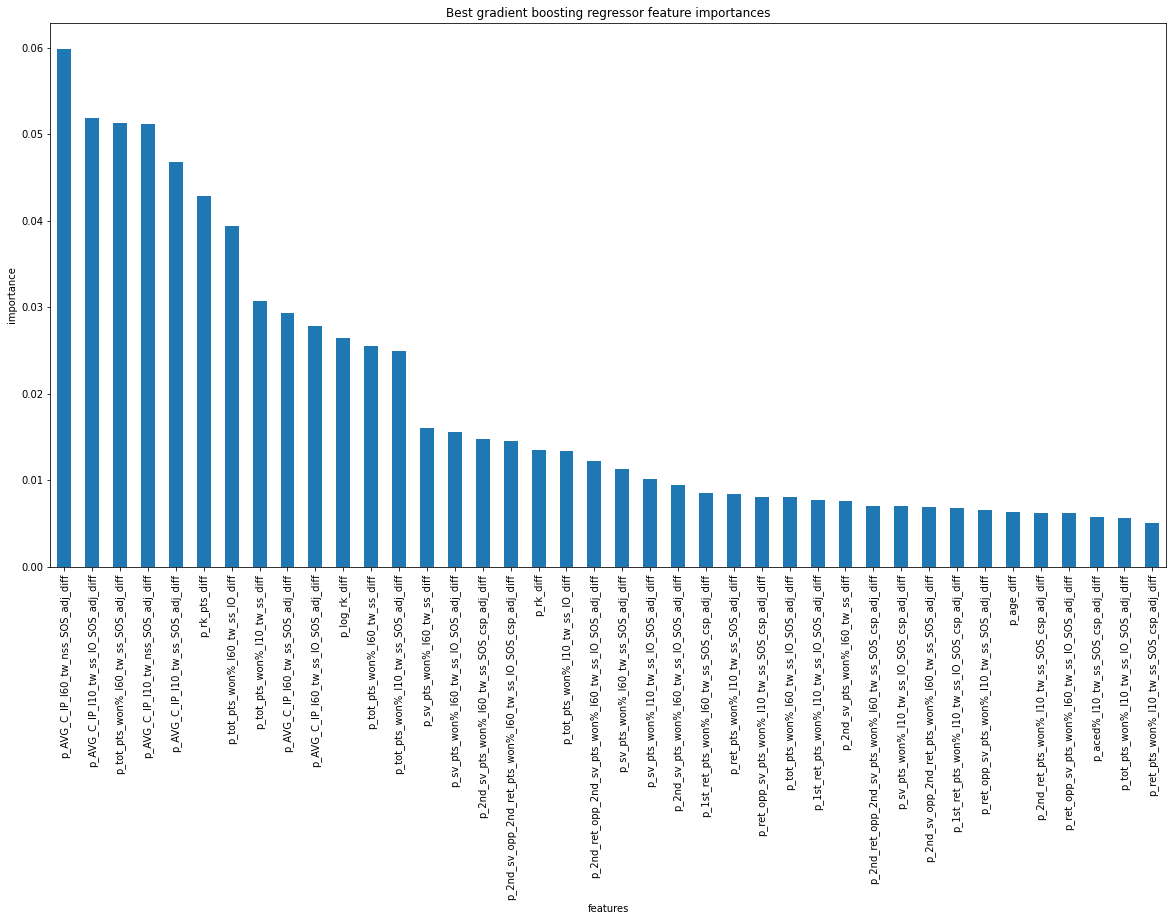

In [1271]:
#Plot a barplot of the gradient boosting model's feature importances,
#assigning the `feature_importances_` attribute of 
#`gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.nlargest(40).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting regressor feature importances');

#feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
# Model Run With ALL Matches (clay and hard) at the same time. 
# NON-equal sample sizes version//min previous matches (ANY surface) 20//2015-2019
# Note: best model hyperparameters were found de novo for this compound model. 

#(5.470845918510179, 0.04116802054308721), 5.551837291178192

In [1272]:
# Model Run With ALL Matches (clay and hard) at the same time. 
# EQUAL sample sizes version//min previous matches (ANY surface) 20//2015-2019
# Note: best model hyperparameters were found de novo for this compound model. Also, ran 10 times (with the best hyperparameters identified on the first run) and took average results to
# account for the random sample of hard court matches in the equal samples analysis. 

# Fourth Run (NON-equal samples version):
# n_est = [165] 
# learning_rate = [.035]
# max_depth = [5]
# max_features = [12]
#'standardscaler': [None]
#'simpleimputer__strategy': ['median']

# Hard Court Sample Size Matched to Clay Court (25 runs and take averages)(3397.5, 1132.5) (2015-2019 in model; thresh of 20):

mean_train_err = [5.545692317053492, 5.504320692732486, 5.5527571865661445, 5.634831532690216, 5.640447221965435, 5.536738540650161, 5.592612354840125, 
                 5.623017688077276, 5.556396508863851, 5.572510663736212, 5.563291227353341, 5.632002977000168, 5.58329275639243,
                 5.576611959179906, 5.572337560181339, 5.588764125474009, 5.58841720223282, 5.5603531792757535, 5.557119790976001,
                 5.611751570663867, 5.595856277544319, 5.55650020053417, 5.547318449772684, 5.586449281905353, 5.5620663874645855,
                 5.616524506466524]  
df1 = pd.DataFrame(mean_train_err, columns=["mean_train_err"])

mean_train_sd = [0.025566645029884934, 0.08760178534344462, 0.0835318475781863, 0.11487188427594222, 0.11546003782968506, 0.10358090390645569, 0.055517657812921554,
                0.12675991843988416, 0.0716319893901964, 0.09341930695008975, 0.05743369700492258, 0.08052785987796557, 0.08029267923477555,
                0.09735816401674659, 0.07259605228974535, 0.08018604425771063, 0.12422207780363544, 0.07217014968563164, 0.10477389313811412,
                0.029084980975329758, 0.07302719507413076, 0.04971619833147886, 0.03962631184533031, 0.10534793107985436, 0.09643528179372374,
                0.04422023576678061]
df2 = pd.DataFrame(mean_train_sd, columns=["mean_train_sd"])

mean_test_err = [5.5469117336788925, 5.384068165612929, 5.5355823820679575, 5.503779367209402, 5.5551273000381265, 5.532749307388589, 5.4758785806428225,
                5.505008801199711, 5.647892367543049, 5.514711861814219, 5.565136999012893, 5.611370661609983, 5.538664266279087,
                5.399806402466166, 5.444554735785562, 5.4536383566465805, 5.526996661050835, 5.52719294831514, 5.510576791143879,
                5.459781822786098, 5.509660494889087, 5.451788027618199, 5.542452152570529, 5.588512190648779, 5.491339245185494,
                5.578247149415557]
df3 = pd.DataFrame(mean_test_err, columns=["mean_test_err"])

df1.mean().round(2), df2.mean().round(2), df3.mean().round(2)


(mean_train_err    5.58
 dtype: float64,
 mean_train_sd    0.08
 dtype: float64,
 mean_test_err    5.52
 dtype: float64)